In [5]:
#My default packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from dataclasses import dataclass
import itertools
import heapq


# Day 1

In [2]:
with open("input1.txt") as f:
    file = f.read()
    calories = [[int(c) for c in s.split("\n")] for s in file.split("\n\n")[:-1]]

In [3]:
calbyelf = [sum(elf) for elf in calories]
max(calbyelf)

70369

In [4]:
sum(sorted(calbyelf)[-3:])

203002

# Day 2

In [10]:
def elfconv(c):
    return next(i for i, el in enumerate(["A","B","C"]) if el ==c)

def youconv(c):
    return next(i for i, el in enumerate(["X","Y","Z"]) if el ==c)

def genconv(c):
    RPS = {"A":0,"B":1,"C":2,"X":0,"Y":1,"Z":2}
    return RPS[c]

fightconvert ={
    0: genconv,
    1: genconv
}

In [11]:
fightlistA = pd.read_csv("input2.txt",header=None,delim_whitespace=True,names=["Elf","You"],converters=fightconvert)
fightlistA["Result"] = ((fightlistA.You-fightlistA.Elf+1)%3)
fightlistA["Score"] = 3*fightlistA.Result+fightlistA.You+1

In [12]:
fightlistA.Score.sum()

9651

In [13]:
fightlistB = pd.read_csv("input2.txt",header=None,delim_whitespace=True,names=["Elf","Result"],converters=fightconvert)
fightlistB["You"] = (fightlistB.Elf+fightlistB.Result-1)%3
fightlistB["Score"] = 3*fightlistB.Result+fightlistB.You+1

In [14]:
fightlistB.Score.sum()

10560

# Day 3

In [34]:
with open("input3.txt") as f:
    rucksacks = []
    while line := f.readline().strip():
        n = len(line)//2
        rucksacks.append(({c for c in line[:n]},{c for c in line[n:]}))

In [33]:
def itempriority(c):
    if c.isupper():
        return 27+ord(c)-ord("A")
    else:
        return 1+ord(c)-ord("a")

In [54]:
commonitem = (l.intersection(r).pop() for l,r in rucksacks)
sum(map(itempriority,commonitem))

7597

In [53]:
fullrucksack = [l.union(r) for l,r in rucksacks]
elvesgroups = [fullrucksack[k:k+3] for k in range(0,len(fullrucksack),3)]
badges = [itempriority(a.intersection(b,c).pop()) for a,b,c in elvesgroups]
sum(badges)

2607

# Day 4

In [69]:
cleanpairs = pd.read_csv("input4.txt",sep=",|-",header=None,names=["elf1min","elf1max","elf2min","elf2max"],engine='python')

In [72]:
cleanpairs["totaloverlap"] = (cleanpairs.elf2min-cleanpairs.elf1min)*(cleanpairs.elf1max-cleanpairs.elf2max)>=0
cleanpairs.totaloverlap.sum()

466

In [73]:
cleanpairs["overlap"] = ~(((cleanpairs.elf2min-cleanpairs.elf1max)>0) | ((cleanpairs.elf1min-cleanpairs.elf2max)>0))
cleanpairs.overlap.sum()

865

# Day 5

In [94]:
def getstacks(f):
    stacks = {k :[] for k in range(1,10)}
    line = f.readline().rstrip()
    while line[1]!= "1":
        for k,c in enumerate(line[1::4]):
            if c!=" ":
                stacks[k+1].insert(0,c)
        line = f.readline().rstrip()
    f.readline()
    return stacks

def getinstructions(f):
    instructions = []
    while line:= f.readline().rstrip():
        instructions.append(list(map(int, line.split(" ")[1::2])))
    return instructions

In [95]:
with open("input5.txt") as f:
    stacks = getstacks(f)
    instructions = getinstructions(f)

for n,f,t in instructions:
    for _ in range(n):
        stacks[t].append(stacks[f].pop())

print("".join(stacks[k][-1] for k in range(1,10)))

RTGWZTHLD


In [96]:
with open("input5.txt") as f:
    stacks = getstacks(f)

for n,f,t in instructions:
    stacks[t] += stacks[f][-n:]
    stacks[f] = stacks[f][:-n]

print("".join(stacks[k][-1] for k in range(1,10)))

STHGRZZFR


# Day 6

In [104]:
with open("input6.txt") as f:
    dstream = f.readline().strip()

In [151]:
class StartofPattern:
    def __init__(self,stream,chunk=4):
        self.chunk = chunk
        self.packet = list(stream[:self.chunk])
        self.pos = self.chunk

    def findpacket(self,stream):
        while len(set(self.packet))<self.chunk:
            try:
                self.packet[(self.pos)%self.chunk] = stream[self.pos]
                self.pos+=1
            except IndexError:
                print("The stream ended without a SoP")
                return -1
        return self.pos

In [152]:
sop = StartofPattern(dstream,chunk=4)
sop.findpacket(dstream)

1175

In [153]:
som = StartofPattern(dstream,chunk=14)
som.findpacket(dstream)

3217

# Day 7

In [111]:
class File:
    def __init__(self,name :str, parent =None,size :int =0) -> None:
        self.name =name
        self.parent = parent
        self._size = size

    def __repr__(self) -> str:
        return f"File({self.name} in {self.parent.name if self.parent else None} (size={self._size}))"

    def size(self):
        return self._size


class Dir(File):
    def __init__(self,name :str, parent=None) -> None:
        File.__init__(self,name,parent)

        self.contains = {}

    def __repr__(self) -> str:
        return f"Dir({self.name} in {self.parent.name if self.parent else None} (contains {len(self.contains)} elements)"

    def size(self):
        return sum(e.size() for e in self.contains.values())
    def add(self,elem):
        self.contains[elem.name] = elem


In [112]:
root = Dir("/")
with open("input7.txt") as f:
    while line:= f.readline().rstrip():
        if line[:4]=="$ cd":
            destination = line.split(" ")[-1]
            if destination=="..":
                curdir=curdir.parent
            elif destination=="/":
                curdir = root
            else:
                curdir=curdir.contains[destination]
        elif line[:4]=="$ ls":
            continue
        else:
            sd,name = line.split(" ")
            if sd=="dir":
                curdir.add(Dir(name,curdir))
            else:
                sd= int(sd)
                curdir.add(File(name,curdir,sd))




In [113]:
def looksmalldirs(dir,maxsize=100000,smaldir=None):
    if smaldir is None:
        smaldir = set()
    if dir.size()<=maxsize:
        smaldir.add(dir)
    for subdir in dir.contains.values():
        if type(subdir) is Dir:
            smaldir = looksmalldirs(subdir,maxsize,smaldir)
    return smaldir
def lookbigdirs(dir,minsize=100000,smaldir=None):
    if smaldir is None:
        smaldir = set()
    if dir.size()>=minsize:
        smaldir.add(dir)
    for subdir in dir.contains.values():
        if type(subdir) is Dir:
            smaldir = lookbigdirs(subdir,minsize,smaldir)
    return smaldir

In [114]:
smoldir = looksmalldirs(root,maxsize=100000)
sum(map(Dir.size,smoldir))

1783610

In [115]:
totaldiskspace = 70000000
neededunusedspace = 30000000

todelete = neededunusedspace-(totaldiskspace-root.size())

bigdir = lookbigdirs(root,minsize=todelete)
min(map(Dir.size,bigdir))

4370655

# Day 8

In [123]:
import cmasher as cmr

In [293]:
forex = """30373
25512
65332
33549
35390"""
forest = np.array([list(map(int,line)) for line in forex.splitlines()])
forestpad = np.pad(forest,1,"constant",constant_values=-1)

In [306]:
with open("input8.txt") as f:
    forest = np.array([list(map(int,line)) for line in f.read().splitlines()])
forestpad = np.pad(forest,1,"constant",constant_values=-1)

(-0.5, 98.5, 98.5, -0.5)

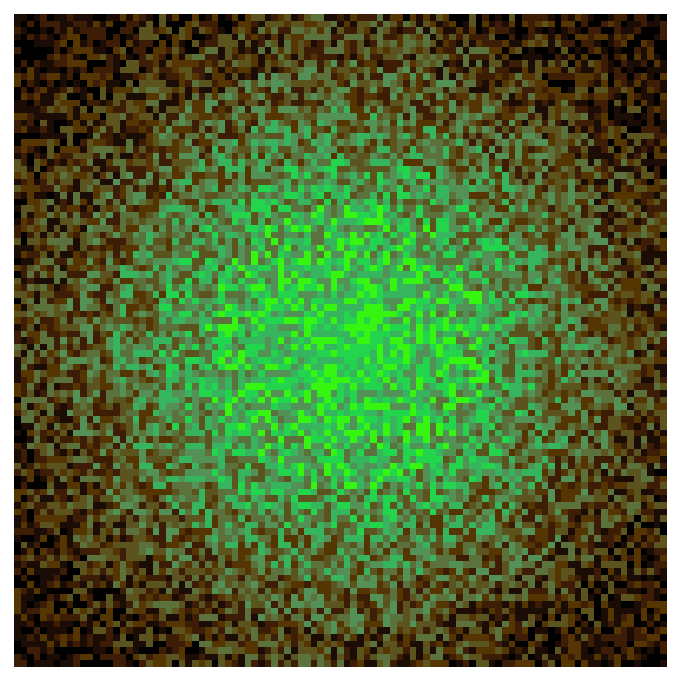

In [321]:
fig,ax = plt.subplots(figsize=(6,6))
ax.imshow(forest,cmap="cmr.tree")
ax.axis('off')

In [168]:
visible = np.zeros_like(forestpad,dtype=bool)
for k in range(1,forestpad.shape[0]-1):
    htreeE = forestpad[:,:k].max(axis=1)
    htreeW = forestpad[:,k+1:].max(axis=1)
    visible[:,k] = visible[:,k] | (forestpad[:,k]>np.minimum(htreeE,htreeW))
for k in range(1,forestpad.shape[1]-1):
    htreeN = forestpad[:k].max(axis=0)
    htreeS = forestpad[k+1:].max(axis=0)
    visible[k] = visible[k] | (forestpad[k]>np.minimum(htreeN,htreeS))

Visible trees : 1851


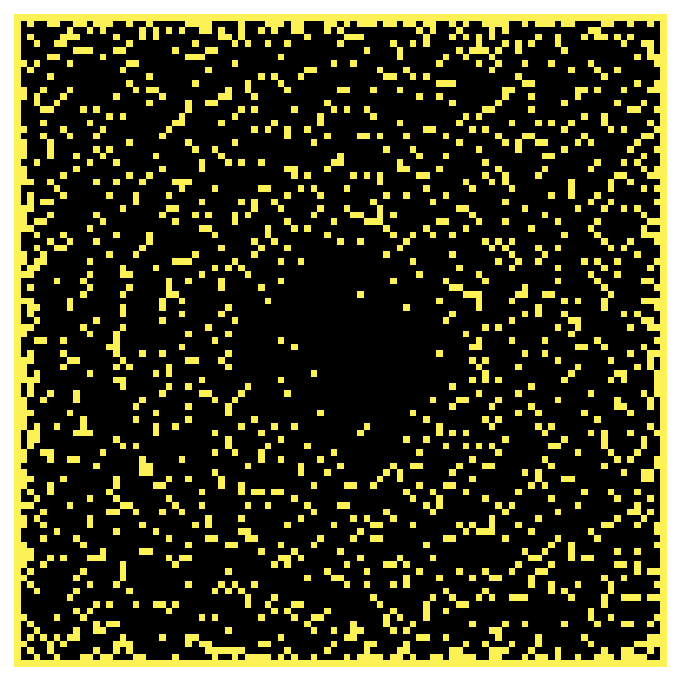

In [322]:
fig,ax = plt.subplots(figsize=(6,6))
ax.imshow(visible[1:-1,1:-1],cmap="cmr.eclipse",)
ax.axis('off')
print(f"Visible trees : {visible.sum()}")

In [324]:
scenicview = np.pad(np.ones_like(forest[1:-1,1:-1],dtype=int),1)
for k in range(1,forest.shape[1]-1):
    treeE =forest[:,k,np.newaxis] <= forest[:,k::-1]
    treeE[:,0]=False
    distanceE = np.argmax(treeE,axis=1)
    distanceE[distanceE==0] = k
    treeW =forest[:,k,np.newaxis] <= forest[:,k:]
    treeW[:,0]=False
    distanceW = np.argmax(treeW,axis=1)
    distanceW[distanceW==0] = forest.shape[1]-1-k
    scenicview[:,k]*=distanceW*distanceE

for k in range(1,forest.shape[0]-1):
    treeN =forest[k,np.newaxis] <= forest[k::-1]
    treeN[0]=False
    distanceN = np.argmax(treeN,axis=0)
    distanceN[distanceN==0] = k
    treeS =forest[k,np.newaxis] <= forest[k:]
    treeS[0]=False
    distanceS = np.argmax(treeS,axis=0)
    distanceS[distanceS==0] = forest.shape[0]-1-k
    scenicview[k]*=distanceS*distanceN

print(f"Highest scenic view : {np.max(scenicview)}")

Highest scenic view : 574080


(-0.5, 98.5, 98.5, -0.5)

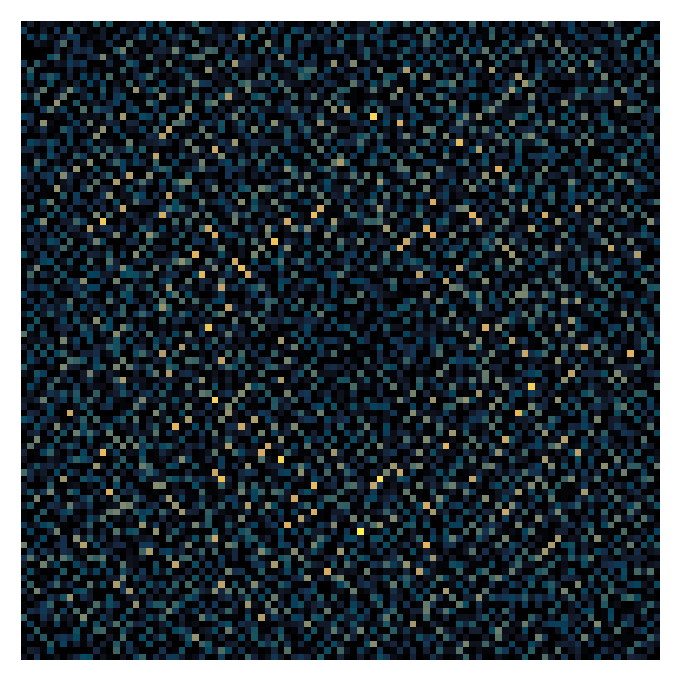

In [326]:
import matplotlib.colors as colors
fig,ax = plt.subplots(figsize=(6,6))
plt.imshow(scenicview,norm=colors.LogNorm(vmin=1, vmax=scenicview.max()),cmap="cmr.eclipse")
plt.axis("off")
# plt.colorbar()
# plt.title("Scenic view")

# Day 9

In [134]:
forestpad[:,:k]

array([], shape=(99, 0), dtype=int64)